In [1]:
import sys
import os
import pickle

import numpy as np
import pandas as pd
import scipy.stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.multitest as multitest
import Bio.AlignIO

import gffutils
from count_trna import parse_trnas

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import Divider, Size
import seaborn as sns
from statannotations.Annotator import Annotator

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams["image.interpolation"] = "none"
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 5
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)

# Helper functions

## Read assignment

In [18]:
"""
Process counted tRNA mappings to annotate their origin (mature vs. pre-tRNA,
locus, transcript, etc.), fragment type (whole, 5' half, 3' half, etc.), and 5'
and 3' end positions in the tRNA sequence.

Raw reads mapped to the tRAX genome are represented as a dict of counts (key ->
count), where each key is a frozenset of mappings, and each mapping is a tuple
(reference_name, mapped_5, mapped_3). Note that the mapping is a half-open
interval where the 5' end is inclusive and the 3' end is exclusive regardless
of the mapped strand (i.e., the 5' end may be greater than the 3' end).

Each key is then processed as follows:

1. For each mapping, identify the corresponding tRNA feature, along with
   associated properties (locus, transcript, anticodon, amino). Note that for
   mature tRNAs, locus and transcript are the same.
2. For each mapping, assign a fragment type (Whole, Fiveprime, Threeprime, or
   Other) based on which end(s) of the tRNA feature the mapping overlaps (5',
   3', both, or neither).
3. For each mapping, assign positions for the 5' and 3' ends of the fragment in
   the tRNA based on the applicable tRNA alignment (pre-tRNA alignment or
   mature tRNA alignment). Note that both 5' and 3' end positions are
   inclusive.
4. For Fiveprime and Threeprime fragments, assign a fragment subtype (tRF-5a,
   tRF-5b, etc.) based on the position of the 5' and 3' ends in the tRNA
   sequence.
5. Summarize a consensus for each of the above properties across mappings in
   the key. If there is a conflict, store the property as a frozenset of
   possible values.
"""

"""parameters for fragment assignment"""
# Whole fragments have both 5' and 3' ends within MAXOFFSET bases from the tRNA
# ends. Fiveprime fragments have one end within MAXOFFSET bases from the 5' end
# of the tRNA, and Threeprime fragments have one end within MAXOFFSET bases
# from the 3' end of the tRNA.
MAXOFFSET = 5
# pre-tRNA fragments extend at least MIN_PRE_TRNA bases beyond either 5' or 3'
# end of the pre-tRNA locus.
MIN_PRE_TRNA = 3
KEY_CACHE = {}


def load_counts(sample, multimapped="ignore"):
    with open(f"counts_trna/JY6_14_{sample}.noumi_counts_2.pkl", "rb") as f:
        counts = pickle.load(f)

    if multimapped == "distribute":
        counts = distribute_multimapped(counts)
    
    df = pd.DataFrame(counts.items(), columns=["key", "count"])

    # filter out reads that are not exclusive to tRNA sequences
    df = df[df["key"].apply(_trna_exclusive)]

    # calculate the length of the fragment
    df["length"] = df["key"].apply(lambda k: np.median([abs(int(x[2]) - int(x[1])) for x in k]))

    # process the key as described above
    df = df.join(df["key"].apply(_process_key))

    # filter out reads that overlap tRNA features on the wrong strand and thus
    # are not assigned to any tRNA feature
    df = df[df["locus"] != set()]
    return df


def distribute_multimapped(counts):
    new_counts = {}
    for key, c in counts.items():
        for mapping in key:
            if frozenset({mapping}) not in new_counts:
                new_counts[frozenset({mapping})] = 0
            new_counts[frozenset({mapping})] += c / len(key)
    return new_counts


def _trna_exclusive(key):
    return "__no_feature" not in key


def _process_key(key):
    if key in KEY_CACHE:
        return KEY_CACHE[key]

    results = [set() for _ in range(11)]
    for k in key:
        mapping = k[:3]
        errors = k[3]
        # process each mapping as described above and update the results
        for i, r in enumerate(_process_mapping(mapping, errors)):
            results[i].update(r)

    # summarize consensus values for each property, or convert to frozenset if
    # ambiguous
    results = [list(r)[0] if len(r) == 1 else frozenset(r) for r in results]

    results = pd.Series(results, index=["locus", "transcript", "anticodon", "amino", 
                                        "type", "fragment", "fragment_type", "aln_5", "aln_3", "spliced", "aln_errors"])
    KEY_CACHE[key] = results
    return results


def _process_mapping(mapping, errors):
    # convert mapping to bam-style ranges and assign to tRNA feature(s) and
    # fragment type(s)
    fwd_strand_range = _mapping_to_forward_strand_range(mapping)
    feats, frags = _assign_trna_mapping(*fwd_strand_range)

    results = [set() for _ in range(11)]
    for feat_idx, frag in zip(feats, frags):
        feat = trnas.loc[feat_idx]
        aln_5, aln_3 = align_mapping(mapping, feat)
        results[0].add(feat.locus)
        results[1].add(feat.transcript)
        results[2].add(feat.anticodon)
        results[3].add(feat.amino)
        results[4].add(feat.type)
        results[5].add(frag)
        results[6].add(_assign_mapping_fragment_subtype(feat.type, frag, aln_5, aln_3))
        results[7].add(aln_5)
        results[8].add(aln_3)
        results[9].add(feat.transcript in spliced)
        results[10].add(
            tuple(sorted(
                align_coordinate(c, feat) for c, _ in errors if c is not None
            ))
        )
    return results


def _mapping_to_forward_strand_range(mapping):
    """convert mapping to a bam-style forward strand range (reference_name, 
    reference_start, reference_end, strand), where reference_start is inclusive 
    and reference_end is exclusive, and reference_start <= reference_end"""
    reference_name, mapped_5, mapped_3 = mapping
    if mapped_3 > mapped_5:
        return reference_name, mapped_5, mapped_3, "+"
    else:
        return reference_name, mapped_3 + 1, mapped_5 + 1, "-"


def _assign_trna_mapping(reference_name, reference_start, reference_end, strand):
    """given mapping return a list of tRNA features that overlap the mapping on 
    the correct strand and corresponding fragment types (typically just one 
    feature and one fragment type)"""
    # get indices of overlapping features
    features = trnas.index[
        (reference_name == trnas.chrom) &
        (reference_start < trnas.chromEnd) &
        (reference_end > trnas.chromStart) & 
        (strand == trnas.strand)
    ].tolist()
    # for each overlapping feature, assign a fragment type
    fragments = [_assign_fragment_mapping(reference_name, reference_start, reference_end, trnas.loc[f]) for f in features]
    return features, fragments


def _assign_fragment_mapping(reference_name, reference_start, reference_end, feature):
    """given mapping and tRNA feature, classify the fragment type as Whole, 
    Fiveprime, Threeprime, or Other"""
    # require that reads mapping to mature tRNAs be entirely contained within
    # the tRNA (i.e., not have extra sequence at the ends), else classify as
    # Other
    if feature.type == "mature" and not (
        reference_start >= feature.chromStart and
        reference_end <= feature.chromEnd
    ):
        return "Other"
    # require that reads mapping to pre-tRNAs extend at least MIN_PRE_TRNA nt
    # beyond the tRNA (i.e., have at least MIN_PRE_TRNA nt of leader and/or
    # trailer), else classify as Other
    if feature.type == "pre" and not (
        reference_start <= feature.chromStart - MIN_PRE_TRNA or
        reference_end >= feature.chromEnd + MIN_PRE_TRNA
    ):
        return "Other"

    # Whole tRNAs have less than MAXOFFSET nt missing from either end
    if reference_start < feature.chromStart + MAXOFFSET and reference_end > feature.chromEnd - MAXOFFSET:
        return "Whole"
    # Fiveprime and Threeprime fragments have less than MAXOFFSET nt missing
    # from one end, but more than MAXOFFSET nt missing from the other end
    elif reference_start < feature.chromStart + MAXOFFSET:
        return "Fiveprime" if feature.strand == "+" else "Threeprime"
    elif reference_end > feature.chromEnd - MAXOFFSET:
        return "Threeprime" if feature.strand == "+" else "Fiveprime"
    # internal fragments are classified as Other
    return "Other"


def align_mapping(mapping, feature):
    """given mapping and tRNA feature, assign positions for the 5' and 3' ends 
    of the fragment in the tRNA based on the applicable tRNA alignment
    
    forward strand feature:
    genomic     0   1   2   3   4   5   6   7   8   9
    feature         |--->--->--->--->--->--->---|
                    [                               )   chromStart: 1, chromEnd: 9
    read                |--->--->--->---|
                        [                   )           mapped_5: 2, mapped_3: 7
                        [               ]               mapped_3_inc: 6

    reverse strand feature:
    genomic     0   1   2   3   4   5   6   7   8   9
    feature         |---<---<---<---<---<---<---|
                    [                               )   chromStart: 1, chromEnd: 9
    read                |---<---<---<---|
                    (                   ]               mapped_5: 6, mapped_3: 1
                        [               ]               mapped_3_inc: 2
    """
    _, mapped_5, mapped_3 = mapping

    if mapped_3 > mapped_5:
        mapped_3_inc = mapped_3 - 1
    else:
        mapped_3_inc = mapped_3 + 1

    aln_5 = align_coordinate(mapped_5, feature)
    aln_3 = align_coordinate(mapped_3_inc, feature)
    return aln_5, aln_3


def align_coordinate(coord, feature):
    """given genomic coordinate and tRNA feature, assign position in the tRNA
    alignment"""
    # calculate distance from 5' end of the tRNA feature
    if feature.strand == "+":
        rel = coord - feature.chromStart
    else:
        rel = feature.chromEnd - coord - 1
    
    feature_length = feature.chromEnd - feature.chromStart
    rec2aln, aln2rec, aln2pos, pos2aln = trnaalign[feature.type]
    
    if rel < 0:
        aln = rel
    elif rel >= feature_length:
        aln = rel - feature_length + len(aln2pos)
    else:
        # look up the position of rel of this tRNA feature in the alignment
        aln = rec2aln[feature.locus][rel]
        
    return aln


def _assign_mapping_fragment_subtype(trna_type, fragment, aln_5, aln_3):
    """given mapping, tRNA feature, and positions of 5' and 3' ends in the tRNA, 
    assign the fragment to a subtype according to Su et al. (Annual Review of 
    Genetics, 2020)"""
    pos2aln = trnaalign[trna_type][3]
    if fragment == "Fiveprime":
        if aln_3 < pos2aln["14"]:
            # upstream of D-loop
            return "Other"
        elif aln_3 < pos2aln["22"]:
            # within D-loop
            return "tRF-5a"
        elif aln_3 < pos2aln["26"]:
            # within D-arm
            return "tRF-5b"
        elif aln_3 < pos2aln["32"]:
            # within anticodon stem
            return "tRF-5c"
        elif aln_3 < pos2aln["39"]:
            # within anticodon loop
            return "5' half"
        else:
            return "Other"
    elif fragment == "Threeprime":
        if aln_5 >= pos2aln["61"]:
            # downstream of T-loop
            return "Other"
        elif aln_5 >= pos2aln["54"]:
            # within T-loop
            return "tRF-3a"
        elif aln_5 >= pos2aln["49"]:
            # within T-arm
            return "tRF-3b"
        elif aln_5 >= pos2aln["39"]:
            # within anticodon stem
            return "tRF-3c"
        elif aln_5 >= pos2aln["32"]:
            # within anticodon loop
            return "3' half"
        else:
            return "Other"
    else:
        return None

In [3]:
"""
Helper functions to filter processed count DataFrames
"""

def mask_unambiguous(col):
    """select rows where the value for a given column is unambiguous"""
    return col.apply(lambda x: type(x) is not frozenset)

def mask_query(col, query):
    """select rows where the value for a given column is, contains, or overlaps
    a query"""
    if type(query) is set:
        return col.apply(lambda x: len(query & x) > 0 if type(x) is frozenset else x in query)
    else:
        return col.apply(lambda x: query in x if type(x) is frozenset else x == query)
    
def mask_anticodon(df, anticodon):
    """select rows where the anticodon unambiguous matches the query"""
    return mask_unambiguous(df["anticodon"]) & mask_query(df["anticodon"], anticodon)

def mask_spliced(df, spliced):
    """select rows that are unambiguously derived from spliced or unspliced tRNAs"""
    return mask_unambiguous(df["spliced"]) & mask_query(df["spliced"], spliced)

def mask_fragment(df, fragment):
    """select rows where the fragment type unambiguous matches the query"""
    return mask_unambiguous(df["fragment"]) & mask_query(df["fragment"], fragment)

def mask_type(df, trna_type):
    """select rows that are unambiguously derived from mature or pre-tRNAs"""
    return mask_unambiguous(df["type"]) & mask_query(df["type"], trna_type)

## Counting

In [4]:
def read_counts_nontrna(file_format, samples):
    c = []
    for run in samples:
        df = pd.read_csv(file_format.format(run), header=None, names=["gene", "count"], sep="\t")
        df = df.set_index("gene")
        df = df.rename({"count": run}, axis=1)
        c.append(df)
    c = pd.concat(c, axis=1, join="outer").sort_index().sort_index().fillna(0)

    # filter out counts for ambiguous reads
    c = c.drop({
        "__alignment_not_unique",
        "__ambiguous",
        "__no_feature",
        "__not_aligned",
        "__too_low_aQual",
    })
    c["miRNA"] = c.index.isin(mirnas)
    c = c.reset_index()
    m = c[["gene", "miRNA"]]
    c = c[["gene"] + list(samples)]

    return c, m

In [5]:
def fragment2genekey_transcript(df):
    return df["type"] + ";" + df["transcript"] + ";" + df["fragment_type"]

def construct_pretrna_count_table(count_dict):
    df_count_table = pd.concat([
        df[
            mask_unambiguous(df["spliced"]) &
            mask_unambiguous(df["transcript"]) &
            mask_type(df, "pre") &
            mask_unambiguous(df["fragment_type"]) & 
            ~mask_query(df["fragment_type"], None) & 
            ~mask_query(df["fragment_type"], "Other")
        ].groupby(["type", "transcript", "fragment_type"])["count"].sum().rename(sample) 
        for sample, df in count_dict.items()], axis=1
    ) \
        .fillna(0) \
        .reset_index() \
        .assign(gene=fragment2genekey_transcript) \
        .drop(["type", "transcript", "fragment_type"], axis=1)
    return df_count_table

In [6]:
def construct_coverage(df, aln_min, aln_max):
    X = np.zeros(aln_max - aln_min + 1)
    for i, row in df.iterrows():
        aln_5 = np.clip(row["aln_5"] - aln_min, 0, aln_max - aln_min)
        aln_3 = np.clip(row["aln_3"] - aln_min, 0, aln_max - aln_min)
        X[aln_5:aln_3+1] += row["count"]
    return pd.Series(X, index=range(aln_min, aln_max + 1))

def construct_error_coverage(df, aln_min, aln_max):
    X = np.zeros(aln_max - aln_min + 1)
    for i, row in df.iterrows():
        for j in row["aln_errors"]:
            if j >= aln_min and j <= aln_max:
                X[j - aln_min] += row["count"]
    return pd.Series(X, index=range(aln_min, aln_max + 1))

def construct_error_rate(df, aln_min, aln_max):
    error = construct_error_coverage(df, aln_min, aln_max)
    coverage = construct_coverage(df, aln_min, aln_max)
    return error / coverage

## Plotting

In [7]:
def plot_coverage(df,
                  trna_type=None, aln_idxs=None, aln_pos=None, aln_x=None,
                  groups=["control", "FXTAS"], palette={"control": "k", "FXTAS": "firebrick"}, 
                  ax=None, **kwargs):
    """
    Plot coverage of tRNAs.

    Args:
        df (pd.DataFrame): DataFrame with rows indexed by tRNA alignment index and columns for each sample.
        trna_type (str): tRNA type ("pre" or "mature"). Plots default positions for the given tRNA type.
        aln_idxs (list): tRNA alignment indices to plot.
        aln_pos (list): tRNA position labels corresponding to aln_idxs.
        aln_x (list): x-axis positions corresponding to aln_idxs.
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6.5, 1))

    if trna_type is not None:
        if trna_type == "pre":
            aln_idxs = ALN_PRE
            aln_pos = [trnaalign["pre"][2][i] for i in ALN_PRE]
        elif trna_type == "mature":
            aln_idxs = ALN_MATURE
            aln_pos = [trnaalign["mature"][2][i] for i in ALN_MATURE]
        else:
            raise ValueError("trna_type must be 'pre' or 'mature'")
    elif aln_idxs is None and aln_pos is None:
        raise ValueError("either trna_type or aln_idxs and aln_pos must be provided")
    
    if aln_x is None:
        aln_x = range(len(aln_idxs))

    df = df.reindex(aln_idxs).fillna(0)
    df = df.rename_axis("index").reset_index()
    df_long = pd.melt(df, var_name="group", value_name="count", id_vars="index")
    mean = df_long.groupby("index")["count"].mean().loc[aln_idxs].values

    ax.bar(x=aln_x, height=mean, **kwargs)
    sns.despine(ax=ax)
    ax.set_xticks(ticks=aln_x[::5], labels=aln_pos[::5])

def plot_end_distribution(df, trna_type=None, aln_idxs=None, aln_pos=None, err=True, scatter=False, dodge=0,
                          groups=["control", "FXTAS"], palette={"control": "k", "FXTAS": "firebrick"}, 
                          ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6.5, 1))

    if trna_type is not None:
        if trna_type == "pre":
            aln_idxs = ALN_PRE
            aln_pos = [trnaalign["pre"][2][i] for i in ALN_PRE]
        elif trna_type == "mature":
            aln_idxs = ALN_MATURE
            aln_pos = [trnaalign["mature"][2][i] for i in ALN_MATURE]
        else:
            raise ValueError("trna_type must be 'pre' or 'mature'")
    elif aln_idxs is None and aln_pos is None:
        raise ValueError("either trna_type or aln_idxs and aln_pos must be provided")
    aln2idx = dict(zip(aln_idxs, range(len(aln_idxs))))

    df = df.reindex(aln_idxs).fillna(0)
    df = df.rename_axis("index").reset_index()
    df["index"] = df["index"].apply(aln2idx.get)
    df_long = pd.melt(df, var_name="group", value_name="count", id_vars="index")

    for i, g in enumerate(groups):
        subset = df_long[df_long["group"] == g]
        mean = subset.groupby("index")["count"].mean()
        se = subset.groupby("index")["count"].sem()
        if err:
            ax.errorbar(mean.index + dodge*(i*2-1), mean, yerr=se, label=sample, fmt=".", c=palette[g], capsize=1, lw=1,**kwargs)
        ax.scatter(mean.index + dodge*(i*2-1), mean, label=sample, c=palette[g], s=8, zorder=10, **kwargs)
    if scatter:
        sns.stripplot(df_long, x="index", y="count", hue="group", palette=palette, dodge=dodge, alpha=0.35, s=4, ax=ax)
    sns.despine(ax=ax)
    ax.set_xticks(ticks=range(len(aln_idxs))[::5], labels=aln_pos[::5])


# Metadata

### Load metadata for tRNAs

In [8]:
def get_spliced_trnas():
    with open("db/spliced_tRNAs.txt", "r") as f:
        spliced = set(f.read().split("\n"))
    return spliced
spliced = get_spliced_trnas()
print(len(spliced), "spliced tRNAs")

trnas = parse_trnas("db")
trnas.head(5)

25 spliced tRNAs


,transcript,locus,amino,anticodon,chrom,chromStart,chromEnd,strand,type
0,tRNA-Ala-AGC-1,tRNA-Ala-AGC-1-1,Ala,AGC,chr6,28795963,28796035,-,pre
1,tRNA-Ala-AGC-10,tRNA-Ala-AGC-10-2,Ala,AGC,chr6,26814338,26814411,-,pre
2,tRNA-Ala-AGC-10,tRNA-Ala-AGC-10-1,Ala,AGC,chr6,26687256,26687329,+,pre
3,tRNA-Ala-AGC-11,tRNA-Ala-AGC-11-1,Ala,AGC,chr6,26571863,26571936,-,pre
4,tRNA-Ala-AGC-12,tRNA-Ala-AGC-12-1,Ala,AGC,chr6,26682486,26682559,+,pre


In [9]:
def read_trna_alignment(path_stk, path_pos):
    """read tRNA alignment from tRAX"""
    align = Bio.AlignIO.read(path_stk, "stockholm")
    rec2aln, aln2rec = {}, {}
    for record in align:
        locus = record.id
        seq = np.array(record.seq)
        rec2aln[locus] = np.array([i for i, c in enumerate(seq) if c != "-"])
        aln2rec[locus] = np.full((len(seq),), -1)
        aln2rec[locus][seq != "-"] = np.arange(len(rec2aln[locus]))
    
    aln2pos = pd.read_csv(
        path_pos, sep="\t", header=None, 
        usecols=[0, 3], names=["index", "position"]
    ).set_index("index").loc[range(align.get_alignment_length()), "position"].values
    pos2aln = dict(zip(aln2pos, range(len(aln2pos))))

    return rec2aln, aln2rec, aln2pos, pos2aln

trnaalign = {
    "pre": read_trna_alignment("db/db-trnaloci.stk", "db/db-locusnum.txt"),
    "mature": read_trna_alignment("db/db-trnaalign.stk", "db/db-alignnum.txt"),
}

In [10]:
"""alignment indices for plotting"""
# 10 nt of leader and trailer
LEADER = list(range(-10, 0))
TRAILER = list(range(len(trnaalign["pre"][2]), len(trnaalign["pre"][2]) + 10))
# pre-tRNA without leader / trailer (with 5 nt of intron)
ALN_PRE_5_NO_LEADER = pd.read_csv("db/pos_pre-tRNA_5.txt", sep="\t", header=None).iloc[:, 0].tolist()
ALN_PRE_3_NO_TRAILER = pd.read_csv("db/pos_pre-tRNA_3.txt", sep="\t", header=None).iloc[:, 0].tolist()
# pre-tRNA 5' and 3' halves
ALN_PRE_5 = LEADER + ALN_PRE_5_NO_LEADER
ALN_PRE_3 = ALN_PRE_3_NO_TRAILER + TRAILER
# mature tRNA 5' and 3' halves (split at intron position)
ALN_MATURE_5 = pd.read_csv("db/pos_mature-tRNA_5.txt", sep="\t", header=None).iloc[:, 0].tolist()
ALN_MATURE_3 = pd.read_csv("db/pos_mature-tRNA_3.txt", sep="\t", header=None).iloc[:, 0].tolist()
# full pre-tRNA (with 10 nt of intron)
ALN_PRE = ALN_PRE_5 + ALN_PRE_3
# full pre-tRNA without intron
ALN_PRE_INTRONLESS = ALN_PRE_5[:-5] + ALN_PRE_3[5:]
# full mature tRNA
ALN_MATURE = ALN_MATURE_5 + ALN_MATURE_3

"""position labels for plotting"""
# 10 nt of leader and trailer
LABEL_LEADER = [f"leader {x}" for x in LEADER]
LABEL_TRAILER = [f"trailer {x - len(trnaalign['pre'][2]) + 1}" for x in TRAILER]
# pre-tRNA 5' and 3' halves (with 5 nt of intron)
LABEL_PRE_5 = LABEL_LEADER + [trnaalign["pre"][2][x] for x in ALN_PRE_5_NO_LEADER]
LABEL_PRE_3 = [trnaalign["pre"][2][x] for x in ALN_PRE_3_NO_TRAILER] + LABEL_TRAILER
# mature tRNA 5' and 3' halves (split at intron position)
LABEL_MATURE_5 = [trnaalign["mature"][2][x] for x in ALN_MATURE_5]
LABEL_MATURE_3 = [trnaalign["mature"][2][x] for x in ALN_MATURE_3]
# full pre-tRNA (with 10 nt of intron)
LABEL_PRE = LABEL_PRE_5 + LABEL_PRE_3
# full pre-tRNA without intron
LABEL_PRE_INTRONLESS = LABEL_PRE_5[:-5] + LABEL_PRE_3[5:]
# full mature tRNA
LABEL_MATURE = LABEL_MATURE_5 + LABEL_MATURE_3

EXON_END_5 = trnaalign["pre"][3]["37"]
EXON_END_3 = trnaalign["pre"][3]["38"]

### Load metadata for non-tRNAs

In [11]:
def get_mirnas():
    db = gffutils.create_db("db/genes.gtf", ':memory:', disable_infer_transcripts=True)
    mirnas = set()
    for f in db.all_features():
        if f.attributes["gene_biotype"][0] == "miRNA":
            mirnas.add(f.attributes["gene_id"][0])
    return mirnas
mirnas = get_mirnas()
print(len(mirnas))

/home/jason/.local/lib/python3.10/site-packages/gffutils/create.py:770: UserWarning: It appears you have a gene feature in your GTF file. You may want to use the `disable_infer_genes=True` option to speed up database creation
  warnings.warn(


1879


# HEK293T data

## Samples and QC

In [12]:
samples293 = pd.DataFrame({"sample": [10, 12],
                           "group": ["FL_DOX", "FL_noDOX"]})
samples293["sample L"] = samples293["sample"].apply(lambda x: str(x) + "_L")
samples293.to_csv("tables/samples_293.csv", sep="\t")
samples293

,sample,group,sample L
0,10,FL_DOX,10_L
1,12,FL_noDOX,12_L


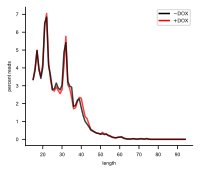

In [14]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))

lengths = []
for s in samples293["sample L"].tolist():
    df = pd.read_csv(f"length/JY6_14_{s}.noumi.length.txt", sep="\t", comment="#", 
                     header=None, usecols=[0, 2], names=["length", s])
    df[s] = df[s].str.rstrip("%").astype(float)
    lengths.append(df.set_index("length"))
lengths = pd.concat(lengths, axis=1, join="outer").fillna(0)
lengths_long = pd.melt(lengths.reset_index(), id_vars="length", var_name="sample", value_name="percent reads")

pal = {"10_L": "r", "12_L": "k"}
sns.lineplot(data=lengths_long, x="length", y="percent reads", hue="sample", 
             palette=pal, alpha=0.75, legend=False,
             ax=ax)
ax.legend(handles=[mlines.Line2D([], [], color="k", label="$-$DOX"),
                   mlines.Line2D([], [], color="r", label="$+$DOX")])
sns.despine(ax=ax)

## Loading, pre-processing, and normalization

### Load count data

In [19]:
counts293 = {}
for sample in samples293["sample L"]:
    counts293[sample] = load_counts(sample)

In [20]:
# tRNA counts
counts_trna_293 = construct_pretrna_count_table(counts293)
counts_trna_293.set_index("gene") \
    .rename(columns=lambda x: "JY6_14_" + x) \
    .to_csv("tables/counts_trna_HEK293T.txt", sep="\t")

# non-tRNA counts
counts_nontrna_293, meta_nontrna_293 = read_counts_nontrna(
    "counts_nontrna/JY6_14_{}.noumi.counts.txt", 
    list(samples293["sample L"])
)
counts_nontrna_293.set_index("gene") \
    .rename(columns=lambda x: "JY6_14_" + x) \
    .to_csv("tables/counts_nontrna_HEK293T.txt", sep="\t")

# miRNA counts
counts_mirna_293 = counts_nontrna_293[meta_nontrna_293["miRNA"]] \
    .set_index("gene") \
    .rename(samples293.set_index("sample L")["sample"].to_dict(), axis=1)
counts_mirna_293.to_csv("tables/counts_mirna_HEK293T.txt", sep="\t")
counts_mirna_293.head(5)

,10,12
gene,,
ENSG00000194717,2,4
ENSG00000198972,2549,925
ENSG00000198973,902,522
ENSG00000198974,15761,8584
ENSG00000198975,92,23


### Compute size factors

In [21]:
!conda run -n deseq Rscript sizeFactors.R tables/samples_293.csv tables/counts_mirna_HEK293T.txt tables/sizeFactors_mirna_293.csv

       10        12 
1.4142136 0.7071068 



In [22]:
mirna_size_factors_293 = pd.read_csv("tables/sizeFactors_mirna_293.csv", sep="\t", header=None, index_col=None).values[:, 0]
samples293["size_factor"] = mirna_size_factors_293
mirna_size_factors_293

array([1.41421356, 0.70710678])

## Coverage and ends

(-10244.174137101014, 260000.0)

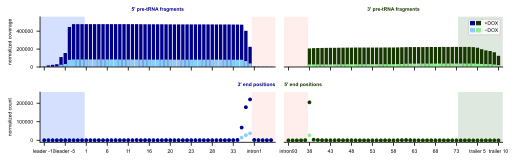

In [23]:
from matplotlib.legend_handler import  HandlerTuple
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(7.1, 2.15))
divider = Divider(fig, (0, 0, 1, 1), 
                    [Size.Fixed(0.5), Size.Scaled(len(ALN_PRE_5)+1), Size.Fixed(0.125), Size.Scaled(len(ALN_PRE_3)+1), Size.Fixed(0.15)],
                    [Size.Fixed(0.2), Size.Scaled(1), Size.Fixed(0.35), Size.Scaled(1), Size.Fixed(0.2)],
                    aspect=False
                  )
axs = np.array([
    [fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=3)),
     fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=3, ny=3)),],
    [fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=1)),
     fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=3, ny=1)),],
])

axs[0, 0].axvspan(-1, 9.5, color="#d5dfff", lw=None, zorder=-10)
axs[1, 0].axvspan(-1, 9.5, color="#d5dfff", lw=None, zorder=-10)
axs[0, 0].axvspan(49.5, len(ALN_PRE_5), color="#ffeeeb", lw=None, zorder=-10)
axs[1, 0].axvspan(49.5, len(ALN_PRE_5), color="#ffeeeb", lw=None, zorder=-10)
axs[0, 1].axvspan(-1, 4.5, color="#ffeeeb", lw=None, zorder=-10)
axs[1, 1].axvspan(-1, 4.5, color="#ffeeeb", lw=None, zorder=-10)
axs[0, 1].axvspan(40.5, len(ALN_PRE_3), color="#dfe8df", lw=None, zorder=-10)
axs[1, 1].axvspan(40.5, len(ALN_PRE_3), color="#dfe8df", lw=None, zorder=-10)

for (sample, row), colors in zip(
    samples293.iterrows(),
    [("darkblue", "#163700"), ("lightskyblue", "lightgreen")]
):
    df = counts293[row["sample L"]]

    cov5 = construct_coverage(
        df[
            mask_spliced(df, True) &
            mask_type(df, "pre") & 
            mask_fragment(df, "Fiveprime") &
            mask_unambiguous(df["aln_3"]) &
            mask_unambiguous(df["aln_5"])
        ],
        min(ALN_PRE),
        max(ALN_PRE)
    ).rename(sample) / row["size_factor"]
    cov5 = pd.DataFrame(cov5)
    plot_coverage(cov5, 
                  aln_idxs=ALN_PRE_5,
                  aln_pos=LABEL_PRE_5,
                  aln_x=list(range(len(ALN_PRE_5))),
                  color=colors[0],
                  ax=axs[0, 0])
    
    cov3 = construct_coverage(
        df[
            mask_spliced(df, True) &
            mask_type(df, "pre") & 
            mask_fragment(df, "Threeprime") &
            mask_unambiguous(df["aln_3"]) &
            mask_unambiguous(df["aln_5"])
        ],
        min(ALN_PRE),
        max(ALN_PRE)
    ).rename(sample) / row["size_factor"]
    cov3 = pd.DataFrame(cov3)
    plot_coverage(cov3, 
                  aln_idxs=ALN_PRE_3,
                  aln_pos=LABEL_PRE_3,
                  aln_x=list(range(len(ALN_PRE_3))),
                  color=colors[1],
                  ax=axs[0, 1])

axs[0, 0].set_xlim((-1, len(ALN_PRE_5)))
axs[0, 0].set_xticklabels([])
axs[0, 0].set_ylim((0, 560000))
axs[0, 0].set_ylabel("normalized coverage")
axs[0, 0].set_title("5' pre-tRNA fragments", size=5, fontdict={"fontweight": "bold", "color": "darkblue"})

axs[0, 1].set_xlim((-1, len(ALN_PRE_3)))
axs[0, 1].set_xticklabels([])
axs[0, 1].spines["left"].set_visible(False)
axs[0, 1].set_ylim((0, 560000))
axs[0, 1].yaxis.set_visible(False)
axs[0, 1].set_title("3' pre-tRNA fragments", size=5, fontdict={"fontweight": "bold", "color": "#163700"})

axs[0, 1].legend([
    (mpatches.Patch(color="darkblue"), mpatches.Patch(color="#163700")),
    (mpatches.Patch(color="lightskyblue"), mpatches.Patch(color="lightgreen"))
], [
    "+DOX",
    "−DOX"
], handler_map={tuple: HandlerTuple(ndivide=None)}, loc="upper right")

plot_end_distribution(
    pd.concat([
        df[
            mask_spliced(df, True) &
            mask_type(df, "pre") & 
            mask_fragment(df, "Fiveprime") &
            mask_unambiguous(df["aln_3"])
        ].groupby("aln_3")["count"].sum().rename(group)
        for group, df in [(row["group"], counts293[row["sample L"]]) for _, row in samples293.iterrows()]
    ], axis=1) / samples293["size_factor"].values, 
    groups=["FL_noDOX", "FL_DOX"],
    palette={"FL_noDOX": "lightskyblue", "FL_DOX": "darkblue"},
    err=False,
    aln_idxs=ALN_PRE_5, 
    aln_pos=LABEL_PRE_5,
    ax=axs[1, 0]
)
axs[1, 0].set_title("3' end positions", size=5, loc="right", fontdict={"fontweight": "bold", "color": "darkblue"})
axs[1, 0].set_xlim((-1, len(ALN_PRE_5)))
axs[1, 0].set_ylim((None, 260000))
axs[1, 0].set_ylabel("normalized count")

plot_end_distribution(
    pd.concat([
        df[
            mask_spliced(df, True) &
            mask_type(df, "pre") & 
            mask_fragment(df, "Threeprime") &
            mask_unambiguous(df["aln_5"])
        ].groupby("aln_5")["count"].sum().rename(group)
        for group, df in [(row["group"], counts293[row["sample L"]]) for _, row in samples293.iterrows()]
    ], axis=1) / samples293["size_factor"].values, 
    groups=["FL_noDOX", "FL_DOX"],
    palette={"FL_noDOX": "lightgreen", "FL_DOX": "#163700"},
    err=False,
    aln_idxs=ALN_PRE_3, 
    aln_pos=LABEL_PRE_3,
    ax=axs[1, 1]
)
axs[1, 1].set_title("5' end positions", size=5, loc="left", fontdict={"fontweight": "bold", "color": "#163700"})
axs[1, 1].set_xlim((-1, len(ALN_PRE_3)))
axs[1, 1].spines["left"].set_visible(False)
axs[1, 1].yaxis.set_visible(False)
axs[1, 1].set_ylim((None, 260000))

## Differential abundance

In [24]:
df_result_293_transcript = counts_trna_293.set_index("gene") \
    .divide(mirna_size_factors_293) \
    .reset_index() \
    .assign(
        type=lambda df: df["gene"].str.split(";").str[0],
        transcript=lambda df: df["gene"].str.split(";").str[1],
        fragment_type=lambda df: df["gene"].str.split(";").str[2]
    ) \
    .assign(
        spliced=lambda df: df["transcript"].isin(spliced)    
    ) \
    .assign(
        log2FoldChange=lambda df: np.log2(df["10_L"] / df["12_L"]),
        baseMean=lambda df: (df["10_L"] + df["12_L"]) / 2,
    ) \
    .drop("gene", axis=1) \
    .query("baseMean > 1")
df_result_293_transcript.head(5)

/home/jason/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,10_L,12_L,type,transcript,fragment_type,spliced,log2FoldChange,baseMean
0,20.506097,7.071068,pre,tRNA-Ala-AGC-11,3' half,False,1.536053,13.788582
1,46.669048,22.627417,pre,tRNA-Ala-AGC-11,5' half,False,1.044394,34.648232
2,48.083261,89.095454,pre,tRNA-Ala-AGC-11,tRF-3a,False,-0.889817,68.589358
3,15.556349,1.414214,pre,tRNA-Ala-AGC-11,tRF-3b,False,3.459432,8.485281
4,45.961941,41.012193,pre,tRNA-Ala-AGC-11,tRF-3c,False,0.164387,43.487067


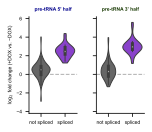

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(2.1, 1.8), sharey=True,)

for ax, fragment_type in zip(axs, ["5' half", "3' half"]):
    # get results corresponding to pre-tRNA fragments of the given type
    df_result_subset = df_result_293_transcript[
        (df_result_293_transcript["fragment_type"] == fragment_type) & 
        (df_result_293_transcript["type"] == "pre") &
        (df_result_293_transcript["baseMean"] > 10)
    ].replace([np.inf, -np.inf], np.nan).dropna()

    ax.axhline(0, color="darkgray", lw=1, ls="--", zorder=-1)
    # sns.pointplot(df_result_subset, x="spliced", y="stat", ax=ax, **kwargs)
    sns.violinplot(df_result_subset, x="spliced", y="log2FoldChange", 
                    cut=0.5,
                    palette=["#666666", "blueviolet"], linewidth=1, saturation=0.75,
                    ax=ax)

    sns.despine(ax=ax)
    ax.set_xlim((-0.5, 1.5))
    ax.set_xticklabels(["not spliced", "spliced"])
    ax.set_xlabel(None)
    axs[0].set_ylabel(r"$\log_2$ fold change (+DOX vs. −DOX)")
    axs[1].set_ylabel(None)
    axs[0].set_ylim((-4.2, 6.2))

axs[0].set_title("pre-tRNA 5' half", size=5, fontdict={"fontweight": "bold", "color": "darkblue"})
axs[1].set_title("pre-tRNA 3' half", size=5, fontdict={"fontweight": "bold", "color": "#163700"})
plt.tight_layout()
fig.subplots_adjust(wspace=0.4)

# Brain data

## Samples and QC

In [26]:
samples = pd.DataFrame({"sample": [1, 2, 3, 4, 5, 6, 7, 8],
                        "group": ["control"]*4 + ["FXTAS"]*4})
samples["sample L"] = samples["sample"].apply(lambda x: str(x) + "_L")
samples.to_csv("tables/samples_brain.csv", sep="\t")
samples

,sample,group,sample L
0,1,control,1_L
1,2,control,2_L
2,3,control,3_L
3,4,control,4_L
4,5,FXTAS,5_L
5,6,FXTAS,6_L
6,7,FXTAS,7_L
7,8,FXTAS,8_L


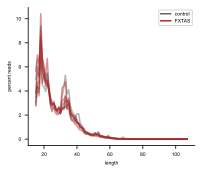

In [28]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))

lengths = []
for s in samples["sample L"].tolist():
    df = pd.read_csv(f"length/JY6_14_{s}.noumi.length.txt", sep="\t", comment="#", 
                     header=None, usecols=[0, 2], names=["length", s])
    df[s] = df[s].str.rstrip("%").astype(float)
    lengths.append(df.set_index("length"))
lengths = pd.concat(lengths, axis=1, join="outer").fillna(0)
lengths_long = pd.melt(lengths.reset_index(), id_vars="length", var_name="sample", value_name="percent reads")

pal = samples.set_index("sample L")["group"].apply({"control": "dimgray", "FXTAS": "firebrick"}.get).to_dict()
sns.lineplot(data=lengths_long, x="length", y="percent reads", hue="sample", 
             palette=pal, alpha=0.5, legend=False,
             ax=ax)
ax.legend(handles=[mlines.Line2D([], [], color="dimgray", label="control"),
                   mlines.Line2D([], [], color="firebrick", label="FXTAS")])
sns.despine(ax=ax)

## Loading, pre-processing, and normalization

### Load count data

In [29]:
counts = {}
for sample in samples["sample L"]:
    counts[sample] = load_counts(sample)

In [62]:
PATH_COUNTS_CACHE = "counts_cache.pkl"
with open(PATH_COUNTS_CACHE, "wb") as f:
    pickle.dump(counts, f)

# PATH_COUNTS_CACHE = "counts_cache.pkl"
# with open(PATH_COUNTS_CACHE, "rb") as f:
#     counts = pickle.load(f)

In [31]:
# tRNA counts
counts_trna = construct_pretrna_count_table(counts)
counts_trna.set_index("gene") \
    .rename(columns=lambda x: "JY6_14_" + x) \
    .to_csv("tables/counts_trna_brain.txt", sep="\t")

# non-tRNA counts
counts_nontrna, meta_nontrna = read_counts_nontrna(
    "counts_nontrna/JY6_14_{}.noumi.counts.txt", 
    list(samples["sample L"])
)
counts_nontrna.set_index("gene") \
    .rename(columns=lambda x: "JY6_14_" + x) \
    .to_csv("tables/counts_nontrna_brain.txt", sep="\t")

# miRNA counts
counts_mirna = counts_nontrna[meta_nontrna["miRNA"]] \
    .set_index("gene") \
    .rename(samples.set_index("sample L")["sample"].to_dict(), axis=1)
counts_mirna.to_csv("tables/counts_mirna_brain.txt", sep="\t")
counts_mirna.head(5)

,1,2,3,4,5,6,7,8
gene,,,,,,,,
ENSG00000194717,858,1061,308,599,549,225,381,1366
ENSG00000198972,12953,20138,5396,12448,9272,3040,8070,27502
ENSG00000198973,32,39,32,154,28,4,33,83
ENSG00000198974,22064,46347,14257,19830,24991,8625,18153,74776
ENSG00000198975,806,1853,448,870,924,303,723,2900


### Compute size factors

In [32]:
!conda run -n deseq Rscript sizeFactors.R tables/samples_brain.csv tables/counts_mirna_brain.txt tables/sizeFactors_mirna_brain.csv

        1         2         3         4         5         6         7         8 
1.0080999 1.7500629 0.7115973 1.1136084 0.9813384 0.4004711 0.7674033 2.3776177 



In [33]:
mirna_size_factors = pd.read_csv("tables/sizeFactors_mirna_brain.csv", sep="\t", header=None, index_col=None).values[:, 0]
samples["size_factor"] = mirna_size_factors
mirna_size_factors

array([1.00809994, 1.75006295, 0.7115973 , 1.11360841, 0.98133836,
       0.40047111, 0.76740325, 2.37761775])

## Coverage and ends

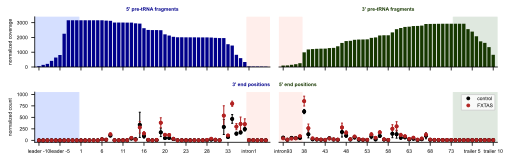

In [34]:
fig = plt.figure(figsize=(7.1, 2.15))
divider = Divider(fig, (0, 0, 1, 1), 
                    [Size.Fixed(0.5), Size.Scaled(len(ALN_PRE_5)+1), Size.Fixed(0.125), Size.Scaled(len(ALN_PRE_3)+1), Size.Fixed(0.15)],
                    [Size.Fixed(0.2), Size.Scaled(1), Size.Fixed(0.35), Size.Scaled(1), Size.Fixed(0.2)],
                    aspect=False
                  )
axs = np.array([
    [fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=3)),
     fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=3, ny=3)),],
    [fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=1)),
     fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=3, ny=1)),],
])

axs[0, 0].axvspan(-1, 9.5, color="#d5dfff", lw=None, zorder=-10)
axs[1, 0].axvspan(-1, 9.5, color="#d5dfff", lw=None, zorder=-10)
axs[0, 0].axvspan(49.5, len(ALN_PRE_5), color="#ffeeeb", lw=None, zorder=-10)
axs[1, 0].axvspan(49.5, len(ALN_PRE_5), color="#ffeeeb", lw=None, zorder=-10)
axs[0, 1].axvspan(-1, 4.5, color="#ffeeeb", lw=None, zorder=-10)
axs[1, 1].axvspan(-1, 4.5, color="#ffeeeb", lw=None, zorder=-10)
axs[0, 1].axvspan(40.5, len(ALN_PRE_3), color="#dfe8df", lw=None, zorder=-10)
axs[1, 1].axvspan(40.5, len(ALN_PRE_3), color="#dfe8df", lw=None, zorder=-10)

plot_coverage(
    pd.concat([
        construct_coverage(
            df[
                mask_spliced(df, True) &
                mask_type(df, "pre") & 
                mask_fragment(df, "Fiveprime") &
                mask_unambiguous(df["aln_3"]) &
                mask_unambiguous(df["aln_5"])
            ],
            min(ALN_PRE),
            max(ALN_PRE)
        ).rename(samples.set_index("sample L")["group"].loc[sample])
        for sample, df in counts.items()
    ], axis=1) / mirna_size_factors, 
    aln_idxs=ALN_PRE_5,
    aln_pos=LABEL_PRE_5,
    aln_x=list(range(len(ALN_PRE_5))),
    color="darkblue",
    ax=axs[0, 0]
)
axs[0, 0].set_xlim((-1, len(ALN_PRE_5)))
axs[0, 0].set_xticklabels([])
axs[0, 0].set_ylim((0, 3400))
axs[0, 0].set_ylabel("normalized coverage")
axs[0, 0].set_title("5' pre-tRNA fragments", size=5, fontdict={"fontweight": "bold", "color": "darkblue"})


plot_coverage(
    pd.concat([
        construct_coverage(
            df[
                mask_spliced(df, True) &
                mask_type(df, "pre") & 
                mask_fragment(df, "Threeprime") &
                mask_unambiguous(df["aln_3"]) &
                mask_unambiguous(df["aln_5"])
            ],
            min(ALN_PRE),
            max(ALN_PRE)
        ).rename(samples.set_index("sample L")["group"].loc[sample])
        for sample, df in counts.items()
    ], axis=1) / mirna_size_factors, 
    aln_idxs=ALN_PRE_3,
    aln_pos=LABEL_PRE_3,
    aln_x=list(range(len(ALN_PRE_3))),
    color="#163700",
    ax=axs[0, 1]
)
axs[0, 1].set_xlim((-1, len(ALN_PRE_3)))
axs[0, 1].set_xticklabels([])
axs[0, 1].spines["left"].set_visible(False)
axs[0, 1].set_ylim((0, 3400))
axs[0, 1].yaxis.set_visible(False)
axs[0, 1].set_title("3' pre-tRNA fragments", size=5, fontdict={"fontweight": "bold", "color": "#163700"})

plot_end_distribution(
    pd.concat([
        df[
            mask_spliced(df, True) &
            mask_type(df, "pre") & 
            mask_fragment(df, "Fiveprime") &
            mask_unambiguous(df["aln_3"])
        ].groupby("aln_3")["count"].sum().rename(samples.set_index("sample L")["group"].loc[sample])
        for sample, df in counts.items()
    ], axis=1) / mirna_size_factors, 
    aln_idxs=ALN_PRE_5, 
    aln_pos=LABEL_PRE_5,
    ax=axs[1, 0]
)
axs[1, 0].set_title("3' end positions", size=5, loc="right", fontdict={"fontweight": "bold", "color": "darkblue"})
axs[1, 0].set_xlim((-1, len(ALN_PRE_5)))
axs[1, 0].set_ylim((None, 1050))
axs[1, 0].set_ylabel("normalized count")

plot_end_distribution(
    pd.concat([
        df[
            mask_spliced(df, True) &
            mask_type(df, "pre") & 
            mask_fragment(df, "Threeprime") &
            mask_unambiguous(df["aln_5"])
        ].groupby("aln_5")["count"].sum().rename(samples.set_index("sample L")["group"].loc[sample])
        for sample, df in counts.items()
    ], axis=1) / mirna_size_factors, 
    aln_idxs=ALN_PRE_3, 
    aln_pos=LABEL_PRE_3,
    ax=axs[1, 1]
)
axs[1, 1].set_title("5' end positions", size=5, loc="left", fontdict={"fontweight": "bold", "color": "#163700"})
axs[1, 1].set_xlim((-1, len(ALN_PRE_3)))
axs[1, 1].spines["left"].set_visible(False)
axs[1, 1].yaxis.set_visible(False)
axs[1, 1].set_ylim((None, 1050))
axs[1, 1].legend(handles=[
    Line2D([0], [0], marker="o", lw=0, ms=8**0.5, color="k", label="control"),
    Line2D([0], [0], marker="o", lw=0, ms=8**0.5, color="firebrick", label="FXTAS"),
], loc="upper right")

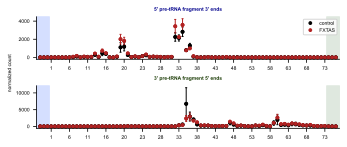

In [35]:
fig, axs = plt.subplots(2, 1, figsize=(4.8, 2), sharex=False, sharey=False)

plot_end_distribution(
    pd.concat([
        df[
            mask_spliced(df, False) &
            mask_type(df, "pre") & 
            mask_fragment(df, "Fiveprime") &
            mask_unambiguous(df["aln_3"])
        ].groupby("aln_3")["count"].sum().rename(samples.set_index("sample L")["group"].loc[sample])
        for sample, df in counts.items()
    ], axis=1) / mirna_size_factors, 
    aln_idxs=ALN_PRE_INTRONLESS[7:-7], 
    aln_pos=LABEL_PRE_INTRONLESS[7:-7],
    ax=axs[0]
)
axs[0].axvspan(-1, 2.5, color="#d5dfff", lw=None, zorder=-10)
axs[0].axvspan(78.5, 82, color="#dfe8df", lw=None, zorder=-10)
axs[0].set_xlim((-1, len(ALN_PRE_INTRONLESS)-14))
axs[0].set_xticks(ticks=range(3, 79, 5), labels=LABEL_PRE_INTRONLESS[10:-10:5])
axs[0].set_title("5' pre-tRNA fragment 3' ends", size=5, fontdict={"fontweight": "bold", "color": "darkblue"})

plot_end_distribution(
    pd.concat([
        df[
            mask_spliced(df, False) &
            mask_type(df, "pre") & 
            mask_fragment(df, "Threeprime") &
            mask_unambiguous(df["aln_5"])
        ].groupby("aln_5")["count"].sum().rename(samples.set_index("sample L")["group"].loc[sample])
        for sample, df in counts.items()
    ], axis=1) / mirna_size_factors, 
    aln_idxs=ALN_PRE_INTRONLESS[7:-7], 
    aln_pos=LABEL_PRE_INTRONLESS[7:-7],
    ax=axs[1]
)
axs[1].axvspan(-1, 2.5, color="#d5dfff", lw=None, zorder=-10)
axs[1].axvspan(78.5, 82, color="#dfe8df", lw=None, zorder=-10)
axs[1].set_xlim((-1, len(ALN_PRE_INTRONLESS)-14))
axs[1].set_xticks(ticks=range(3, 79, 5), labels=LABEL_PRE_INTRONLESS[10:-10:5])
axs[1].set_title("3' pre-tRNA fragment 5' ends", size=5,  fontdict={"fontweight": "bold", "color": "#163700"})

axs[0].legend(handles=[
    Line2D([0], [0], marker="o", lw=0, ms=8**0.5, color="k", label="control"),
    Line2D([0], [0], marker="o", lw=0, ms=8**0.5, color="firebrick", label="FXTAS"),
], loc="upper right")

fig.supylabel("normalized count", size=5)
plt.tight_layout()

### Fraction ends at exon boundary

/tmp/ipykernel_12092/4140986569.py:61: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(df, x="spliced", y="fraction", ax=ax, palette=["k", "blueviolet"], alpha=0.25)
/tmp/ipykernel_12092/4140986569.py:61: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(df, x="spliced", y="fraction", ax=ax, palette=["k", "blueviolet"], alpha=0.25)
/home/jason/.local/lib/python3.10/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/jason/.local/lib/python3.10/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Custom statistical test, P_val:7.767e-04
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Custom statistical test, P_val:1.457e-03


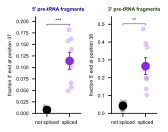

In [36]:
def calculate_fraction_ends(df, name, fragment, aln_end, aln):
    """calculate the fraction of reads that end at a given position in the tRNA
    alignment, grouped by anticodon/spliced"""
    return pd.pivot(
        # select pre-tRNAs that are unambiguously derived from spliced or
        # unspliced tRNAs and have unambiguous end position
        df[
            mask_type(df, "pre") &
            mask_unambiguous(df["anticodon"]) &
            mask_fragment(df, fragment) & 
            mask_unambiguous(df[aln_end])
        ] \
            # get counts for each end position
            .groupby(["anticodon", "spliced", aln_end])["count"].sum() \
            .reset_index(), 
        # pivot into table of counts with anticodons as rows, position as columns
        index=["anticodon", "spliced"], columns=aln_end, values="count"
    ).fillna(0) \
        .apply(lambda x: x / x.sum(), axis=1)[aln].rename(name)

# construct table of fractions of 5' pre-tRNA reads with 3' end at position 37,
# averaged across anticodons
df_5 = pd.concat([
    calculate_fraction_ends(df, sample, "Fiveprime", "aln_3", EXON_END_5)
    for sample, df in counts.items()
], axis=0, join="outer", keys=samples["sample"]) \
    .rename("fraction") \
    .reset_index() \
    .groupby(["sample", "spliced"])["fraction"].mean() \
    .reset_index()
# test if fraction is different between spliced and unspliced pre-tRNAs using
# paired t-test
pval5 = scipy.stats.ttest_rel(
    df_5.query("spliced").set_index("sample").loc[samples["sample"], "fraction"],
    df_5.query("not spliced").set_index("sample").loc[samples["sample"], "fraction"],
    alternative="two-sided",
).pvalue

# construct table of fractions of 3' pre-tRNA reads with 5' end at position 38,
# averaged across anticodons
df_3 = pd.concat([
    calculate_fraction_ends(df, sample, "Threeprime", "aln_5", EXON_END_3)
    for sample, df in counts.items()
# concatenate into long-form DataFrame with index sample/anticodon/spliced
], axis=0, join="outer", keys=samples["sample"]) \
    .rename("fraction") \
    .reset_index() \
    .groupby(["sample", "spliced"])["fraction"].mean() \
    .reset_index()
# test if fraction is different between spliced and unspliced pre-tRNAs using
# paired t-test
pval3 = scipy.stats.ttest_rel(
    df_3.query("spliced").set_index("sample").loc[samples["sample"], "fraction"],
    df_3.query("not spliced").set_index("sample").loc[samples["sample"], "fraction"],
    alternative="two-sided",
).pvalue

fig, axs = plt.subplots(1, 2, figsize=(2.2, 1.8), sharey=False,)
kwargs = dict(errorbar="se", errwidth=1, capsize=0.1, join=False, palette=["k", "blueviolet"], order=[False, True])
for ax, df, p in zip(axs, [df_5, df_3], [pval5, pval3]):
    sns.stripplot(df, x="spliced", y="fraction", ax=ax, palette=["k", "blueviolet"], alpha=0.25)
    sns.pointplot(df, x="spliced", y="fraction", ax=ax, **kwargs)
    sns.despine(ax=ax)
    ax.set_xticklabels(["not spliced", "spliced"])
    ax.set_xlabel(None)
    ax.set_xlim((-0.5, 1.5))

axs[0].set_ylabel("fraction 3' end at position 37")
axs[0].set_ylim((0, 0.15))
axs[0].set_title("5' pre-tRNA fragments", size=5, fontdict={"fontweight": "bold", "color": "darkblue"})

axs[1].set_ylabel("fraction 5' end at position 38")
axs[1].set_ylim((0, 0.35))
axs[1].set_title("3' pre-tRNA fragments", size=5, fontdict={"fontweight": "bold", "color": "#163700"})

fig.tight_layout()

for ax, df, p in zip(axs, [df_5, df_3], [pval5, pval3]):
    pairs = [(False, True)]
    annotator = Annotator(ax, pairs, data=df, x="spliced", y="fraction")
    annotator.configure(test=None, test_short_name="paired t-test", line_width=0.5)
    annotator.set_pvalues([p])
    annotator.annotate()

## Modifications

In [37]:
anticodons = ["GTA", "TCT", "TAT", "CAA"]

err_mature = pd.concat([
    # concatenate vertically across anticodons
    pd.concat([
        # concatenate horizontally across samples
        construct_error_rate(df[
            mask_anticodon(df, anticodon) &
            mask_type(df, "mature") &
            mask_unambiguous(df["fragment_type"]) & mask_query(df["fragment_type"], {"5' half", "3' half"}) &
            mask_unambiguous(df["aln_5"]) &
            mask_unambiguous(df["aln_3"]) &
            mask_unambiguous(df["aln_errors"])
        ], min(ALN_MATURE), max(ALN_MATURE)) \
            .loc[ALN_MATURE] \
            .set_axis(pd.Index(LABEL_MATURE)) \
            .rename(sample)
        for sample, df in counts.items()
    ], axis=1)
    for anticodon in anticodons
], axis=0, keys=anticodons)

err_pre = pd.concat([
    # concatenate vertically across anticodons
    pd.concat([
        # concatenate horizontally across samples
        construct_error_rate(df[
            mask_anticodon(df, anticodon) &
            mask_type(df, "pre") &
            mask_unambiguous(df["fragment_type"]) & mask_query(df["fragment_type"], {"5' half", "3' half"}) &
            mask_unambiguous(df["aln_5"]) &
            mask_unambiguous(df["aln_3"]) &
            mask_unambiguous(df["aln_errors"])
        ], min(ALN_PRE_INTRONLESS[10:-10]), max(ALN_PRE_INTRONLESS[10:-10])) \
            .loc[ALN_PRE_INTRONLESS[10:-10]] \
            .set_axis(pd.Index(LABEL_PRE_INTRONLESS[10:-10])) \
            .rename(sample)
        for sample, df in counts.items()
    ], axis=1)
    for anticodon in anticodons
], axis=0, keys=anticodons)

In [38]:
err = pd.concat([err_mature, err_pre], axis=1, keys=["mature", "pre"], join="inner").rename_axis(["anticodon", "position"])
pos_subset = err["mature"].mean(axis=1) > 0.25
err[pos_subset]

mature                                          \
                         1_L       2_L       3_L       4_L       5_L   
anticodon position                                                     
GTA       26        0.750000  0.774566  0.579208  0.701299  0.792079   
          37        0.705993  0.843782  0.657016  0.708955  0.824061   
          58        0.906571  0.886158  0.892609  0.929773  0.918520   
TCT       9         0.904215  0.855191  0.906433  0.936508  0.805825   
          32        0.515670  0.511978  0.639250  0.733591  0.562500   
          58        0.967894  0.969844  0.968540  0.967080  0.967323   
TAT       9         0.432692  0.286058  0.562802  0.511811  0.622351   
          58        0.960720  0.960668  0.953182  0.943291  0.955662   
CAA       26        0.851695  0.930679  0.834113  0.866460  0.926882   
          37        0.854701  0.863111  0.798278  0.765286  0.807525   
          58        0.990104  0.990123  0.992870  0.986985  0.990294   

                                                       pre            \
                         6_L       7_L       8_L       1_L       2_L   
anticodon position                                                     
GTA       26        0.445378  0.751323  0.685345  0.103448  0.076142   
          37        0.562701  0.598214  0.719536  0.044444  0.005076   
          58        0.921379  0.893872  0.918772  0.687970  0.771916   
TCT       9         0.846154  0.791367  0.725581  0.296703  0.188482   
          32        0.416290  0.634884  0.360000  0.000000  0.000000   
          58        0.967871  0.965410  0.964767  0.914286  0.960526   
TAT       9         0.652913  0.543967  0.506862  0.132597  0.073069   
          58        0.957808  0.952597  0.950869  0.900000  0.924370   
CAA       26        0.772167  0.706994  0.835345  0.352941  0.280344   
          37        0.719178  0.695101  0.528757  0.015873  0.006601   
          58        0.991235  0.984146  0.986650  1.000000  0.937500   

                                                                                
                         3_L       4_L       5_L       6_L       7_L       8_L  
anticodon position                                                              
GTA       26        0.106383  0.033537  0.151351  0.105263  0.118421  0.037363  
          37        0.000000  0.011429  0.000000  0.000000  0.000000  0.006342  
          58        0.766756  0.522095  0.821086  0.811060  0.684350  0.457181  
TCT       9         0.142857  0.123457  0.191489  0.115385  0.119565  0.132461  
          32        0.000000  0.000000  0.000000  0.038462  0.000000  0.000000  
          58        1.000000  0.857143  0.962963  0.928571  1.000000  0.953642  
TAT       9         0.141333  0.092537  0.136662  0.089157  0.083333  0.082920  
          58        0.840237  0.942308  0.929204  0.971429  0.915254  0.950172  
CAA       26        0.290837  0.284123  0.374254  0.194831  0.196364  0.168923  
          37        0.019231  0.000000  0.000000  0.038462  0.000000  0.006051  
          58        1.000000  0.800000  1.000000  1.000000  0.750000  0.988235

/tmp/ipykernel_12092/1963268156.py:18: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(df_subset,
/tmp/ipykernel_12092/1963268156.py:18: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(df_subset,
/tmp/ipykernel_12092/1963268156.py:18: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(df_subset,
/tmp/ipykernel_12092/1963268156.py:18: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(df_subset,
/tmp/ipykernel_12092/1963268156.py:18: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(df_subset,
/tmp/ipykernel_12092/1963268156.py:18: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(df_subset,
/tmp/ipykernel_12092/1963268156.py:18: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(df_subset,
/tmp/ipykernel_12092/1963268156.py

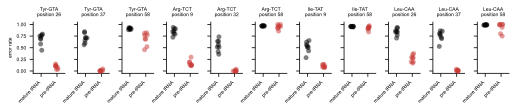

In [39]:
fig, axs = plt.subplots(1, 11, figsize=(7.1, 1.5), sharey=True)
df = pd.melt(err[pos_subset].reset_index(), var_name=["type", "sample"], id_vars=["anticodon", "position"], value_name="error")

anticodon2amino = {
    "GTA": "Tyr",
    "TCT": "Arg",
    "TAT": "Ile",
    "CAA": "Leu",
}

for ax, (anticodon, position) in zip(axs, [
    ("GTA", "26"), ("GTA", "37"), ("GTA", "58"),
    ("TCT", "9"), ("TCT", "32"), ("TCT", "58"),
    ("TAT", "9"), ("TAT", "58"),
    ("CAA", "26"), ("CAA", "37"), ("CAA", "58"),
]):
    df_subset = df.query(f"anticodon == '{anticodon}' and position == '{position}'")
    sns.stripplot(df_subset,
                  x="type", y="error", order=["mature", "pre"], 
                  palette=dict(mature="k", pre="#c93b36"), alpha=0.5, legend=False,
                  ax=ax)
    
    sns.despine(ax=ax)
    ax.set_xlabel(None)
    ax.set_xticks([0, 1], ["mature tRNA", "pre-tRNA"], rotation=45, ha="right")
    ax.set_title(f"{anticodon2amino[anticodon]}-{anticodon}\nposition {position}", size=5)

axs[0].set_ylabel("error rate")

plt.tight_layout()
fig.subplots_adjust(wspace=0.4)

## Differential abundance

In [40]:
# run DESeq2
!conda run -n deseq Rscript DE.R tables/samples_brain.csv control FXTAS tables/counts_trna_brain.txt tables/counts_mirna_brain.txt tables/de_results_brain.csv

        1         2         3         4         5         6         7         8 
1.0080999 1.7500629 0.7115973 1.1136084 0.9813384 0.4004711 0.7674033 2.3776177 
log2 fold change (MLE): group FXTAS vs control 
Wald test p-value: group FXTAS vs control 
DataFrame with 6 rows and 6 columns
                            baseMean log2FoldChange     lfcSE       stat
                           <numeric>      <numeric> <numeric>  <numeric>
pre;tRNA-Ala-AGC-11;tRF-3a  1.946950      -0.513382  1.476633 -0.3476705
pre;tRNA-Ala-AGC-17;tRF-5a  0.247991      -1.389768  3.508980 -0.3960604
pre;tRNA-Ala-AGC-18;tRF-3c  0.322799      -0.227185  3.080303 -0.0737542
pre;tRNA-Ala-AGC-8;3' half  7.065456       0.215125  0.875803  0.2456314
pre;tRNA-Ala-AGC-8;5' half 13.874170       0.572723  0.718751  0.7968318
pre;tRNA-Ala-AGC-8;tRF-3a  26.955170       0.364246  0.843310  0.4319244
                              pvalue      padj
                           <numeric> <numeric>
pre;tRNA-Ala-AGC-11;tRF-3a  0.728

In [41]:
# read DESeq2 result and parse table
df_result_transcript = pd.read_csv("tables/de_results_brain.csv", sep="\t") \
                .assign(
                    type=lambda df: df["gene"].str.split(";").str[0],
                    transcript=lambda df: df["gene"].str.split(";").str[1],
                    fragment_type=lambda df: df["gene"].str.split(";").str[2]
                ) \
                .assign(
                    spliced=lambda df: df["transcript"].isin(spliced)    
                ) \
                .drop("gene", axis=1) \
                .query("baseMean > 1")
df_result_transcript.head(5)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,type,transcript,fragment_type,spliced
0,1.946950,-0.513382,1.476633,-0.347671,0.728088,0.992539,pre,tRNA-Ala-AGC-11,tRF-3a,False
3,7.065456,0.215125,0.875803,0.245631,0.805968,0.992539,pre,tRNA-Ala-AGC-8,3' half,False
4,13.874170,0.572723,0.718751,0.796832,0.425549,0.992539,pre,tRNA-Ala-AGC-8,5' half,False
5,26.955170,0.364246,0.843310,0.431924,0.665796,0.992539,pre,tRNA-Ala-AGC-8,tRF-3a,False
6,1.627789,-1.824559,1.751688,-1.041600,0.297597,0.992539,pre,tRNA-Ala-AGC-8,tRF-3b,False


### Gene set statistics using camera

In [42]:
# subset out relevant data for each fragment type
for fragment_type in {"5' half", "tRF-5a", "tRF-5b", "tRF-5c", "3' half", "tRF-3a", "tRF-3b", "tRF-3c"}:
    os.makedirs(f"tables/camera_transcript/{fragment_type}", exist_ok=True)

    df_result_subset = df_result_transcript[
        (df_result_transcript["type"] == "pre") &
        (df_result_transcript["fragment_type"] == fragment_type)
    ]
    counts_log = (counts_trna.set_index("gene")
                    .loc[fragment2genekey_transcript(df_result_subset)] 
                    / mirna_size_factors
                ).apply(lambda c: np.log2(c+1))

    counts_log.to_csv(f"tables/camera_transcript/{fragment_type}/counts.csv", sep="\t")
    df_result_subset.set_index(fragment2genekey_transcript(df_result_subset))["stat"].to_csv(f"tables/camera_transcript/{fragment_type}/stats.csv", sep="\t")
    df_result_subset.set_index(fragment2genekey_transcript(df_result_subset)).query("spliced").index.to_series().rename(fragment_type).to_csv(f"tables/camera_transcript/{fragment_type}/set.csv", sep="\t")

In [43]:
# run camera
!conda run -n deseq Rscript camera.R tables/samples_brain.csv control FXTAS tables/camera_transcript/5\'\ half
!conda run -n deseq Rscript camera.R tables/samples_brain.csv control FXTAS tables/camera_transcript/tRF-5a
!conda run -n deseq Rscript camera.R tables/samples_brain.csv control FXTAS tables/camera_transcript/tRF-5b
!conda run -n deseq Rscript camera.R tables/samples_brain.csv control FXTAS tables/camera_transcript/tRF-5c
!conda run -n deseq Rscript camera.R tables/samples_brain.csv control FXTAS tables/camera_transcript/3\'\ half
!conda run -n deseq Rscript camera.R tables/samples_brain.csv control FXTAS tables/camera_transcript/tRF-3a
!conda run -n deseq Rscript camera.R tables/samples_brain.csv control FXTAS tables/camera_transcript/tRF-3b
!conda run -n deseq Rscript camera.R tables/samples_brain.csv control FXTAS tables/camera_transcript/tRF-3c

$vif
[1] 7.460971

$correlation
[1] 0.07022795

        NGenes Direction       PValue
5' half     12        Up 0.0005764983

$vif
[1] 41.3635

$correlation
[1] 0.4118725

       NGenes Direction    PValue
tRF-5a     14        Up 0.2443544

$vif
[1] 6.235069

$correlation
[1] 0.1745023

       NGenes Direction    PValue
tRF-5b      2      Down 0.4608429

$vif
[1] 7.177398

$correlation
[1] 0.1625631

       NGenes Direction    PValue
tRF-5c      5        Up 0.2504372

$vif
[1] 10.54855

$correlation
[1] 0.09181302

        NGenes Direction     PValue
3' half     12        Up 0.02001993

$vif
[1] 45.50432

$correlation
[1] 0.383658

       NGenes Direction    PValue
tRF-3a     10        Up 0.3612287

$vif
[1] 18.7366

$correlation
[1] 0.3346527

       NGenes Direction   PValue
tRF-3b      6        Up 0.744543

$vif
[1] 35.99019

$correlation
[1] 0.3152269

       NGenes Direction    PValue
tRF-3c     13        Up 0.3211887



In [44]:
# read camera result and parse table
df_camera_result_transcript = pd.concat([
    pd.read_csv(f"tables/camera_transcript/{fragment}/result.csv", sep="\t")
    for fragment in ["5' half", "tRF-5a", "tRF-5b", "tRF-5c", "3' half", "tRF-3a", "tRF-3b", "tRF-3c"]
])
df_camera_result_transcript

,NGenes,Direction,PValue
5' half,12,Up,0.000576
tRF-5a,14,Up,0.244354
tRF-5b,2,Down,0.460843
tRF-5c,5,Up,0.250437
3' half,12,Up,0.020020
tRF-3a,10,Up,0.361229
tRF-3b,6,Up,0.744543
tRF-3c,13,Up,0.321189


### Plot 5' and 3' pre-tRNA half abundance

In [45]:
def plot_fragment_abundance(fragment_type_left, fragment_type_right):
    fig, axs = plt.subplots(1, 2, figsize=(2.1, 1.8), sharey=True,)
    # kwargs = dict(errorbar="se", errwidth=1, capsize=0.1, join=False, palette=["k", "blueviolet"])

    for ax, fragment_type in zip(axs, [fragment_type_left, fragment_type_right]):
        # get results corresponding to pre-tRNA fragments of the given type
        df_result_subset = df_result_transcript[
            (df_result_transcript["fragment_type"] == fragment_type) & 
            (df_result_transcript["type"] == "pre")
        ]
        ax.axhline(0, color="darkgray", lw=1, ls="--", zorder=-1)
        # sns.pointplot(df_result_subset, x="spliced", y="stat", ax=ax, **kwargs)
        sns.violinplot(df_result_subset, x="spliced", y="stat", 
                       cut=0.5,
                       palette=["#666666", "blueviolet"], linewidth=1, saturation=0.75,
                       ax=ax)

        sns.despine(ax=ax)
        ax.set_xlim((-0.5, 1.5))
        ax.set_xticklabels(["not spliced", "spliced"])
        ax.set_xlabel(None)
        axs[0].set_ylabel("Wald statistic (FXTAS vs. control)")
        axs[1].set_ylabel(None)
        # axs[0].set_ylim((-0.6, 2.2))
        axs[0].set_ylim((-3.2, 4.2))

        pairs = [(False, True)]
        annotator = Annotator(ax, pairs, data=df_result_subset, x="spliced", y="stat", plot="violinplot", cut=0.5)
        annotator.configure(test=None, test_short_name="camera", line_width=0.5)
        annotator.set_pvalues([df_camera_result_transcript.loc[fragment_type, "PValue"]])
        annotator.annotate()
    
    return fig, axs

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Custom statistical test, P_val:5.765e-04
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Custom statistical test, P_val:2.002e-02


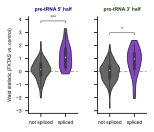

In [46]:
fig, axs = plot_fragment_abundance("5' half", "3' half")
axs[0].set_title("pre-tRNA 5' half", size=5, fontdict={"fontweight": "bold", "color": "darkblue"})
axs[1].set_title("pre-tRNA 3' half", size=5, fontdict={"fontweight": "bold", "color": "#163700"})
plt.tight_layout()
fig.subplots_adjust(wspace=0.4)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Custom statistical test, P_val:2.444e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Custom statistical test, P_val:3.612e-01


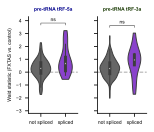

In [47]:
fig, axs = plot_fragment_abundance("tRF-5a", "tRF-3a")
axs[0].set_title("pre-tRNA tRF-5a", size=5, fontdict={"fontweight": "bold", "color": "darkblue"})
axs[1].set_title("pre-tRNA tRF-3a", size=5, fontdict={"fontweight": "bold", "color": "#163700"})
plt.tight_layout()
fig.subplots_adjust(wspace=0.4)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Custom statistical test, P_val:4.608e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Custom statistical test, P_val:7.445e-01


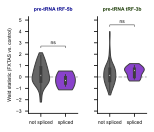

In [48]:
fig, axs = plot_fragment_abundance("tRF-5b", "tRF-3b")
axs[0].set_title("pre-tRNA tRF-5b", size=5, fontdict={"fontweight": "bold", "color": "darkblue"})
axs[1].set_title("pre-tRNA tRF-3b", size=5, fontdict={"fontweight": "bold", "color": "#163700"})
plt.tight_layout()
fig.subplots_adjust(wspace=0.4)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Custom statistical test, P_val:2.504e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Custom statistical test, P_val:3.212e-01


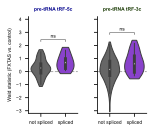

In [49]:
fig, axs = plot_fragment_abundance("tRF-5c", "tRF-3c")
axs[0].set_title("pre-tRNA tRF-5c", size=5, fontdict={"fontweight": "bold", "color": "darkblue"})
axs[1].set_title("pre-tRNA tRF-3c", size=5, fontdict={"fontweight": "bold", "color": "#163700"})
plt.tight_layout()
fig.subplots_adjust(wspace=0.4)

## Correlation with RIN

In [51]:
rin = pd.read_excel("RIN_combined.xlsx")
rin.index = rin["sample"].apply(str) + "_L"
rin = rin[["eRIN"]]
rin

,eRIN
sample,
1_L,6.8
2_L,6.2
3_L,4.8
4_L,7.0
5_L,6.2
6_L,5.5
7_L,6.7
8_L,7.9


In [52]:
# normalize counts by size factor and construct long-form DataFrame
# pseudocount and log2 transform
df_counts_normalized = counts_trna.set_index("gene") / mirna_size_factors

df = pd.melt(df_counts_normalized[df_counts_normalized.mean(axis=1) > 1].applymap(lambda c: np.log2(c+1)).reset_index(), id_vars="gene", var_name="sample", value_name="count") \
    .assign(
        case=lambda df: df["sample"].isin({"5_L", "6_L", "7_L", "8_L"}),
        eRIN=lambda df: df["sample"].map(rin["eRIN"]),
        type=lambda df: df["gene"].str.split(";").str[0],
        transcript=lambda df: df["gene"].str.split(";").str[1],
        fragment_type=lambda df: df["gene"].str.split(";").str[2]
    ) \
    .assign(
        spliced=lambda df: df["transcript"].isin(spliced),
    )
df.head(5)

,gene,sample,count,case,eRIN,type,transcript,fragment_type,spliced
0,pre;tRNA-Ala-AGC-11;tRF-3a,1_L,0.994192,False,6.8,pre,tRNA-Ala-AGC-11,tRF-3a,False
1,pre;tRNA-Ala-AGC-8;3' half,1_L,1.991280,False,6.8,pre,tRNA-Ala-AGC-8,3' half,False
2,pre;tRNA-Ala-AGC-8;5' half,1_L,2.312625,False,6.8,pre,tRNA-Ala-AGC-8,5' half,False
3,pre;tRNA-Ala-AGC-8;tRF-3a,1_L,3.448855,False,6.8,pre,tRNA-Ala-AGC-8,tRF-3a,False
4,pre;tRNA-Ala-AGC-8;tRF-3b,1_L,2.575270,False,6.8,pre,tRNA-Ala-AGC-8,tRF-3b,False


In [53]:
# perform eRIN regression on each fragment type separately
fragment_types = ["5' half", "tRF-5a", "tRF-5b", "tRF-5c", "3' half", "tRF-3a", "tRF-3b", "tRF-3c"]
pvals = {}
coefs = {}
for f_type in fragment_types:
    # select spliced pre-tRNA fragments of the given type
    df_subset = df[
        (df["fragment_type"] == f_type) & 
        (df["type"] == "pre") & 
        df["spliced"]
    ]

    if len(df_subset) == 0:
        pvals[f_type] = np.nan
        continue

    # perform linear regression of log2 count against eRIN, case vs. control, and gene/fragment
    model = smf.ols("count ~ eRIN + C(case) + C(gene)", df_subset)
    result = model.fit()

    # calculate one-sided p-value for eRIN coefficient (test for negative correlation)
    deg = result.df_resid
    t = result.tvalues["eRIN"]
    p = scipy.stats.t(deg).cdf(t)

    pvals[f_type] = p
    coefs[f_type] = result.params["eRIN"]

ols_result = pd.DataFrame([coefs, pvals], index=["coef", "p"]).T

# adjust p-values for multiple testing
mask = ~ols_result["p"].isna()
ols_result["padj"] = np.nan
ols_result.loc[mask, "padj"] = multitest.multipletests(ols_result.loc[mask, "p"], method="fdr_bh")[1]
ols_result

,coef,p,padj
5' half,0.363921,9.995256e-01,9.995256e-01
tRF-5a,-0.862463,2.852063e-15,2.281650e-14
tRF-5b,-0.018773,4.776277e-01,5.458602e-01
tRF-5c,-0.531335,1.052499e-02,1.683998e-02
3' half,-0.145911,6.372207e-02,8.496276e-02
tRF-3a,-0.952610,2.269245e-11,9.076980e-11
tRF-3b,-1.223819,4.058463e-09,8.116926e-09
tRF-3c,-0.734261,1.164695e-09,3.105854e-09


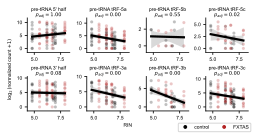

In [54]:

fig, axs = plt.subplots(2, 4, figsize=(3.5, 1.8))

for ax, f_type, title in zip(
    axs.flatten(), 
    ["5' half", "tRF-5a", "tRF-5b", "tRF-5c", "3' half", "tRF-3a", "tRF-3b", "tRF-3c"],
    ["pre-tRNA 5' half", "pre-tRNA tRF-5a", "pre-tRNA tRF-5b", "pre-tRNA tRF-5c", "pre-tRNA 3' half", "pre-tRNA tRF-3a", "pre-tRNA tRF-3b", "pre-tRNA tRF-3c"],
):
    df_subset = df[
        (df["fragment_type"] == f_type) & 
        (df["type"] == "pre") & 
        df["spliced"]
    ]
    sns.scatterplot(df_subset, x="eRIN", y="count", hue="case", palette=["k", "firebrick"], alpha=0.25, s=10, legend=False, ax=ax)
    sns.regplot(df_subset, x="eRIN", y="count", scatter=False, color="k", ax=ax)
    ax.set_title(title, size=5, pad=7)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.tick_params(axis="both", length=2.5, pad=2.5)
    ax.margins(x=0.15, y=0.15)
    sns.despine(ax=ax)

    if len(df_subset) == 0:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        sns.despine(ax=ax, left=True, bottom=True)
        ax.annotate("n.d.", xy=(0.5, 0.5), xycoords="axes fraction", ha="center", va="center")
        continue

    p = ols_result.loc[f_type, "padj"]
    ax.annotate("$p_{{adj}} = {:.2f}$".format(p), xy=(0.5, 1.05), xycoords="axes fraction", ha="center")

axs[1, -1].legend(handles=[
    Line2D([0], [0], marker="o", lw=0, ms=8**0.5, color="k", label="control"),
    Line2D([0], [0], marker="o", lw=0, ms=8**0.5, color="firebrick", label="FXTAS"),
], loc="lower right", bbox_to_anchor=(1, 0), ncol=2, bbox_transform=fig.transFigure)

fig.supylabel(r"$\log_2 ($normalized count $+1)$", size=5)
fig.supxlabel("RIN", size=5, y=0.05)

plt.subplots_adjust(left=0.1, bottom=0.18, right=0.98, top=0.9, wspace=0.4, hspace=0.7)